# Introduction to Dataset
## Data Description
**Data Source:** Our data was sourced from my (Nate Teuber) brother who was very gracious and gave us access to his CGM and Insulin Pump data (See below).

The dataset we are using is comprised of 2.5 years of insulin dosage, blood glucose (bg), and Estimated Variability of Glucose (EVG). This data was collected from a type 1 diabetic's insulin pump and continuous glucose monitor (CGM). Unfortunately this data isnt entirely continous over the 2.5 year span and has gaps in some instances. This data has been exported directly from 30 day span .csv files containing 3 tables one for insulin dosage (bolus), bg, and EVG data. We split these files into the 3 respective tables and saved them to new tables containing the full time-span of data, these files are titles Bolus.csv, BG.csv, and EVG.csv. Here I will detail the contents of these files.

1. Bolus
    * Features:
        * Type: Type of bolus event (Always 'Bolus').
        * BolusType: Describes the wayin which the Bolus was used (categorical).
        * BolusDeliveryMethod: Method used to deliver the bolus (Auto or Standard)(categorical).
        * BG (mg/dL): Blood glucose levels at the time of bolus administration (continuous data).
        * SerialNumber: Device identifier.
        * CompletionDateTime: Timestamp when the dosing was completed.
        * InsulinDelivered: The standard unit measure for the amount of insulin delivered (continuous data).
        * FoodDelivered: Insulin delivered for food consumption (continuous data).
        * CorrectionDelivered: Insulin delivered for BG correction (continuous data).
        * CompletionStatusDesc: Status description of the dosage (categorical).
        * BolexStartDateTime: Not Used In Export.
        * BolexCompletionDateTime: Not Used In Export.
        * BolexInsulinDelivered: Not Used In Export.
        * BolexCompletionStatusDesc: Not Used In Export.
        * StandardPercent: (Always 100).
        * Duration (mins):(Always 0).
        * CarbSize: The amount of carbohydrates consumed in grams (continuous data).
        * TargetBG (mg/dL): Target blood glucose level for the subject in milligrams per deciliter (continuous data).
        * CorrectionFactor: Insulin sensitivity factor (continuous data).
        * CarbRatio: Insulin-to-carbohydrate ratio (continuous data).
    * Notes:
        * This table holds the most detailed records for insulin dosing decisions, food intake, and blood glucose corrections.
        * This table will be very useful in modeling relationships between carbohydrate intake, insulin dosage, and BG levels.
        * Bolus (Def: A large single doseage of insuline to lower a bloodsugar rise) refers to the device/method of insuline delivery. Which is automated through a pocket size device with a refillable tank of insulin.
2. EVG Table
    * Features:
        * DeviceType: Type/Name of the device used to record the event.
        * SerialNumber: Device identifier.
        * Description: A text description of the type of data recorded (Always EVG).
        * EventDateTime: Timestamp of when the measurement was recorded.
        * Readings (mg/dL): The estimated glucose level at the recorded time, in milligrams per deciliter (mg/dL).
    * Notes: 
        * The EVG data is collected directly from a CGM.
        * EVG is designed for tracking overall trends and patterns in glucose levels rather than moment-to-moment decisions.
        * Useful for identifying time-in-range, glucose variability, and predicting hypo/hyperglycemia over time.
        
3. BG Table
    * Features:
        * DeviceType: Type/Name of device used to measure blood glucose.
        * SerialNumber: Device identifier.
        * Description: A text description of the type of data recorded (Always BG)
        * EventDateTime: Timestamp of the blood glucose measurement.
        * BG (mg/dL): Blood glucose levels in milligrams per deciliter (continuous data).
        * Note: Additional notes field (Always Blank).
    * Notes:
        * This data is manually entered and is recorded through a glucometer (Finger Prick).
        * The BG measurement reflects the actual glucose levels at the time of measurement.


### General Dataset Properties

* Total \# of Features:
    * Bolus: 18 features
    * EVG: 5 features
    * BG: 6 features
* \# of Usable/Useful Features: (!!!!! Update possibly)
    * Bolus: 12 features
    * EVG: 2 features
    * BG: 2 features
* Table Sizes:
    * Bolus: 11,348 Records
    * EVG: 191,781 Records
    * BG: 2,832 Records
* Unique Dates: 
    * Bolus: 599 Days
    * EVG: 666 Days
    * BG: 663 Days
* Intersecting Dates: 599

## Preprocessing

### Methodology for Data Preprocessing
Given the nature of our Time Series problem, after initial testing we identified some issues with the bolus data not being recorded at consistent intervals and only when administering insulin. To remedy this given that our EVG data is continous we decided to fill the gaps in our data with blank bolus records, only adding a 'Type' field equal to 'EVG', to denote the different types of records, and also adding the BG readings while setting the rest of the numeric fields to 0 and categorical fields to blank. 
Below I detail the preprocessing process and outline the methods used.

**1. Data Import and Initial Setup**
* Loading Data:
  * We decided to use the `EVG.csv` and `Bolus.csv` files as pandas DataFrames.
  * In the function `convert_data(df):` we prepare the `EVG` data by mapping it to match the `Bolus` table structure for consistent formatting across datasets.
* Merging Tables:
  * We merged the `EVG` and `Bolus` tables into a single dataset using pandas' `concat` function filling the gaps in time.

**2. Data Cleaning**
* Datetime Conversion:
  * Converted the `CompletionDateTime` column to the dataframe index.
  * Rounded the `CompletionDateTime` to the nearest 5-minute interval to standardize timestamps.
  * Identified and removed rows where the `CompletionDateTime` overlapped with `CGM` data to avoid redundancy or conflicting records.
  * Dropped all data before 2024 to ensure continous data throughout the set.

**3. Data Transformation**
  * Applied one-hot encoding to categorical columns, such as `Type`, `BolusType`, `BolusDeliveryMethod`, and `CompletionStatusDesc`, to prepare them for machine learning models.
    * We considered using encodings to map categorical values but resorted to one-hot encoding as it was more familiar to us.
  * Removed columns that were not relevant or consistently populated (`SerialNumber`, `BolexStartDateTime`, `BolexCompletionDateTime`, etc.).
  * Converted boolean columns to integer type for min-max scaling.
  * Re-ordered columns and set the Date value as the Dataframe index.
  * Ensured no missing values (`NaN`) remained in the dataset.
  * Normalized the data using `MinMaxScaler` to normalize numeric fields to a range of [0, 1].


### Function Descriptions

**1. `round_to_nearest_5_minutes(df)`**
* Purpose: To ensure all timestamps (`CompletionDateTime`) in the dataset are standardized by rounding them to the nearest 5-minute interval.
* Steps:
  1. Converts the `CompletionDateTime` column to datetime format.
  2. Drops rows with invalid or missing datetime values.
  3. Rounds valid `CompletionDateTime` values to the nearest 5-minute interval.


**2. `remove_cgm_on_time_overlap(df)`**
* Purpose: To remove redundant or conflicting data points from the dataset when multiple records share the same timestamp.
* Steps:
  1. Identifies duplicate `CompletionDateTime` entries across the dataset.
  2. Filters out rows where the `Type` is `CGM` and the timestamp overlaps with other records.


**3. `convert_data(df)`**
* Purpose: To map the structure of the `EVG` table to match the `Bolus` table schema, enabling consistent formatting and integration.
* Steps:
  1. Creates a template `Bolus` table structure with predefined columns.
  2. Renames relevant columns in the `EVG` data to align with the `Bolus` schema.
  3. Adds missing columns to the mapped `EVG` table, using default values for both numeric and categorical fields.
  4. Reorders the columns to match the `Bolus` table structure.


**4. `onehot_encoding(df)`**
* Purpose: To transform specified categorical columns into one-hot encoded vectors.
* Steps:
  1. Uses pandas' `get_dummies()` method to create binary indicator columns for each category in the specified columns.



In [67]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def round_to_nearest_5_minutes(df):
    # Ensure CompletionDateTime is in datetime format
    df['CompletionDateTime'] = pd.to_datetime(df['CompletionDateTime'], errors='coerce')
    # Drop rows with invalid datetime entries
    df = df.dropna(subset=['CompletionDateTime'])
    # Round CompletionDateTime to the nearest 5 minutes
    df['CompletionDateTime'] = df['CompletionDateTime'].dt.round('5min')
    return df

def remove_cgm_on_time_overlap(df):
    # Identify duplicates based on CompletionDateTime
    duplicate_times = df[df.duplicated('CompletionDateTime', keep=False)]
    # Filter out rows where Type is EVG and CompletionDateTime is duplicated
    df = df[~((df['CompletionDateTime'].isin(duplicate_times['CompletionDateTime'])) & (df['Type'] == 'CGM'))]
    
    return df

def convert_data(df):
    # Example Bolus table columns
    bolus_columns = [
        'Type', 'BolusType', 'BolusDeliveryMethod', 'BG (mg/dL)', 'SerialNumber',
        'CompletionDateTime', 'InsulinDelivered', 'FoodDelivered', 'CorrectionDelivered',
        'CompletionStatusDesc', 'BolexStartDateTime', 'BolexCompletionDateTime', 
        'BolexInsulinDelivered', 'BolexCompletionStatusDesc', 'StandardPercent', 
        'Duration (mins)', 'CarbSize', 'TargetBG (mg/dL)', 'CorrectionFactor', 'CarbRatio'
    ]

    # 1. Create a template DataFrame for Bolus table with default values
    template_bolus = pd.DataFrame(columns=bolus_columns)

    # Default values for missing fields
    default_numeric = 0
    default_categorical = ''

    # 2. Map EVG fields to Bolus fields
    mapped_bolus = evg_df.rename(columns={
        'Readings (mg/dL)': 'BG (mg/dL)',
        'SerialNumber': 'SerialNumber',
        'EventDateTime': 'CompletionDateTime'
    })

    # 3. Add missing columns with default values
    for col in bolus_columns:
        if col not in mapped_bolus.columns:
            if col in ['BG (mg/dL)', 'InsulinDelivered', 'FoodDelivered', 'CorrectionDelivered', 
                    'StandardPercent', 'Duration (mins)', 'CarbSize', 'TargetBG (mg/dL)', 
                    'CorrectionFactor', 'CarbRatio']:  # Numeric fields
                mapped_bolus[col] = default_numeric
            elif col == 'Type':
                mapped_bolus[col] = 'CGM'
            else:  # Categorical fields
                mapped_bolus[col] = default_categorical

    # 4. Reorder columns to match the Bolus table structure
    mapped_bolus = mapped_bolus[bolus_columns]

    # Resulting Bolus DataFrame
    #print(mapped_bolus)
    return mapped_bolus

def onehot_encoding(df, columns):
    df = pd.get_dummies(df, columns=columns)
    return df

# Load the CSV files into pandas DataFrames
#file_path1 = './DataTables/BG.csv'  # Replace with the actual path for Table 1
file_path2 = './DataTables/EVG.csv'  # Replace with the actual path for Table 2
file_path3 = './DataTables/Bolus.csv'  # Replace with the actual path for Table 3

# Load the data
#df1 = pd.read_csv(file_path1)
evg_df = pd.read_csv(file_path2)
bolus_df = pd.read_csv(file_path3)

evg_mapped = convert_data(evg_df)

df = pd.concat([bolus_df, evg_mapped], ignore_index=True)

# Round CompletionDateTime to the nearest 5 minutes
df = round_to_nearest_5_minutes(df)

# Sort the DataFrame by CompletionDateTime
df = df.sort_values(by='CompletionDateTime').reset_index(drop=True)
df = remove_cgm_on_time_overlap(df)
columns=['Type', 'BolusType', 'BolusDeliveryMethod', 'CompletionStatusDesc']

# Apply the function
columns=['SerialNumber', 'BolexStartDateTime', 'BolexCompletionDateTime', 'BolexInsulinDelivered', 'BolexCompletionStatusDesc', 'Type', 'BolusType', 'BolusDeliveryMethod', 'CompletionStatusDesc']
df = df.drop(columns=columns)
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)
df.rename(columns={'CompletionDateTime': 'Date'}, inplace=True)

# Move the 'Date' column to the first position
first_col = df.pop('Date')  # Remove 'Date' column
df.insert(0, 'Date', first_col)  # Reinsert it at position 0

# Write the DataFrame
df.to_csv('merged_data.csv', index=False)

# Organize data, make date into an index
df.set_index("Date", inplace=True)
values = df.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Choosing a Model

### Baseline
**Random Selection**:

Here, we created a baseline by making a function which simply randomly selects a float value in the range from 0 to 400 — the range our dataset's BG levels were recorded in. The MAE, RMSE, and Variance values will be explained in better detail later in this notebook, but for now we want to record them as a baseline metric to compare our model against.

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
import numpy as np
import random

def randomSelector(a=0, b=400, num_entries=1000):
    y_hat = []
    for i in range(num_entries):
        y_hat.append(random.uniform(a=a, b=b))
    return y_hat

y = df['BG (mg/dL)'].values
y_hat = randomSelector(num_entries=len(df))

# calculate MAE
mae = np.sqrt(mean_absolute_error(y, y_hat))
print('Test MAE: %.3f' % mae)
# calculate RMSE
rmse = np.sqrt(root_mean_squared_error(y, y_hat))
print('Test RMSE: %.3f' % rmse)
# calculate Variance
variance = rmse - mae
print('Test Variance: %.3f' % variance)

Test MAE: 11.094
Test RMSE: 12.253
Test Variance: 1.159


**Mean Selection**:

Here, we created a baseline by simply always predicting the mean of our dataset's BG level readings.

In [69]:
def meanSelector(mean=200, num_entries=1000):
    y_hat = []
    for i in range(num_entries):
        y_hat.append(mean)
    return y_hat

y = df['BG (mg/dL)'].values
y_hat = meanSelector(mean=np.mean(y), num_entries=len(df))

# calculate MAE
mae = np.sqrt(mean_absolute_error(y, y_hat))
print('Test MAE: %.3f' % mae)
# calculate RMSE
rmse = np.sqrt(root_mean_squared_error(y, y_hat))
print('Test RMSE: %.3f' % rmse)
# calculate Variance
variance = rmse - mae
print('Test Variance: %.3f' % variance)

Test MAE: 8.778
Test RMSE: 9.746
Test Variance: 0.968


### Introduction to Time Series
Initially, we considered using linear regression. However, sources online, as well as our professor, informed us that our problem was better framed as a "Time Series" problem and that Neural Networks are excellently suited for tackling these kinds of problems. We will get to Neural Networks and the model we chose in a minute, but first, what is a Time Series?

*GeeksforGeeks* defines a Time Series as, "a sequence of data points collected, recorded, or measured at successive, evenly-spaced time intervals." Most of our data certainly fits this criteria. We have a long record of various biological data collected over the course of eight months at intervals of five minutes. However, some of our data was recorded at irregular time intervals. We address this later in our section on Data Preprocessing, but we ultimately decided to merge the two datasets and the round the irregular time records to the nearest five-minute mark. This way, we have consistent intervals, and by sacrificing some precision in timing, we gain a wealth of information about food consumption times, carbs consumed, insulin delivered, etc.



### Components of a Time Series
Digging a little deeper into Time Series, we see that Time Series have four main components:
* **Trend**: The long-term movement of data over the course of the entire timeframe. An example would be rising air temperatures over the course of decades.
* **Seasonality**: Periodic patterns that occur at regular intervals in the data. An example would be daily changes in temperature or even changes in temperature over the course of the four seasons.
* **Cycles**: Long-term fluctuations which do not have a fixed period. An example would be market boom and bust cycles. These consistently happen, but not at regular intervals.
* **Noise**: Randomness or unpredictable changes in the data

With the exception of cycles, these components are easy to identify in our data. We've visualized Trend and Seasonality in the code cells below. Noise is readily visible in both visualizations as well.

#### Trends
In the plot below, you can see some trends in the data. Blood Glucose level is relatively consistent, as would be expected for a healthy person. You can see, however, that insulin dosage goes up over time. This is because Nate's brother has grown and gained weight over time. The gaps in the data are from when his brother stopped doing manual entries and corrections, at least as recorded by these devices. For our dataset, we will only use the complete data after these gaps.

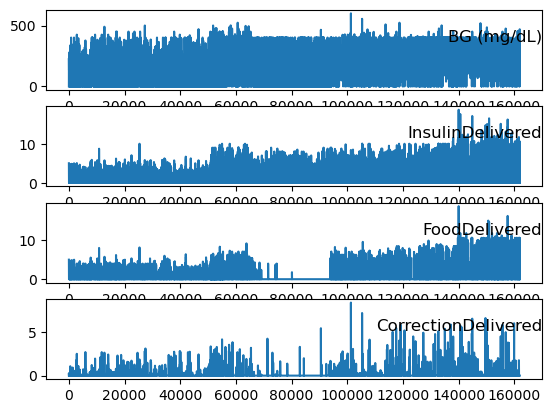

In [70]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### Daily Seasonality
In this plot, we have averaged out daily BG levels, grouped by hour of the day. So 0 = midnight, 12 = noon, etc. We can clearly see a wave-like, seasonal pattern formed in the data hovering around 200 mg/dL.

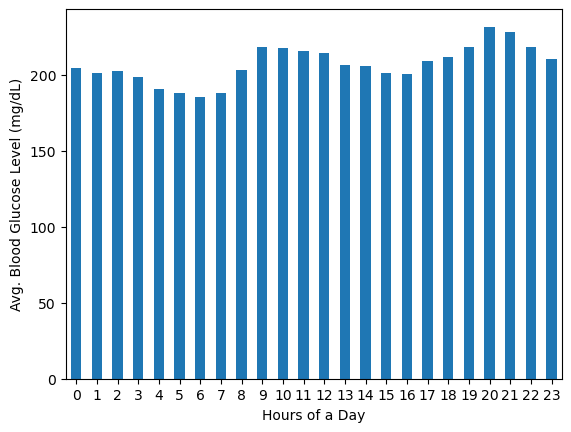

In [71]:
data = pd.read_csv('merged_data.csv')
data.groupby(pd.to_datetime(data['Date']).dt.hour)['BG (mg/dL)'].mean().plot( kind='bar', rot=0, xlabel="Hours of a Day", ylabel="Avg. Blood Glucose Level (mg/dL)" );

### Recurrent Neural Networks
So, addressing this problem as a Time Series seems to be appropriate. What kind of model should we use to make predictions on this series? Our professor suggested Neural Networks, and further research lead us to discover Recurrent Neural Networks in particular. The basic idea of an RNN is this: Imagine someone hands you a picture of a cube (with no background or anything) and asks you to predict which direction it will travel next. Obviously, you'd just be guessing. But if someone handed you a sequence of pictures of the cube over time, you could take a reasonable guess. This applies to an RNN. The point of an RNN is that it keeps track of previous states as sequential patterns, just like the sequence of pictures of the cube, and just like a Time Series. That way, it can make better predictions. However, RNNs suffer from very short-term memory. By the end of the sequence you have fed the RNN, it gives equal weight to the current step in the sequence it's on and all previous steps prior. This results in an exponential loss.

### RNNs Improved: Long-Short Term Memory
By adding extra functions and steps to the "hidden state" in the RNN which keeps track of the prior states, data scientists have been able to create much longer memory for the RNN, which is crucial for our dataset comprised of data recorded at 5-minute intervals spanning over months. There are a few versions of these improved RNNs, but the most popular ones are Long-Short Term Memory (LSTM) models and Gated Recurrent Unit (GRU) models. For this project, we have decided to go with the LSTM, simply because there seems to be more readily available info out there on this type of model.

# Tutorial by Jason Brownlee

This project's implementation of an LSTM was largely based on a very comprehensive Python tutorial by Jason Brownlee on the website MachineLearningMastery.com. A link is in the credits section in this notebook. We used the *multivariate* version of his implementation because we want to input multiple features into our LSTM. The function below is directly from his tutorial and most of our LSTM's implementation was a direct modification of his code. Our data preparation was also informed by his tutorial.

In [72]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Implementation of LSTM Tutorial Code

### Multiple Timesteps

The "n_in" parameter in Jason's series_to_supervised() function allows us to transform the data such that each feature's time series is matched by *n* other time series of the feature which are offset by (t-1, t-2, ..., t-n) timesteps. If we leave it at default, we can then see, once we print the head of the dataframe, that it has output two timesteps for each variable. For variable 1, our blood glucose level as shown in the code cell above, there is var1(t-1) and var1(t). If you run the code cell below, you will notice that the time series var1(t-1) is the same series as var1(t) except that the entire series is offset one step into the past. This is the same for every one of the variables / features.

It will be more convenient for us to do this later, but if we culled the last three timesteps, we would be left with a dataframe containing four of previous timestep series for all of our features (var1(t-1), var2(t-2), var3(t-3), var4(t-4)) — our input variables — and one timestep series for the current blood glucose level (var1(t)) — our output variable.

In [73]:
# Transform to supervised set with one timestep
df_reframed = series_to_supervised(scaled, n_in=1, n_out=1)
print(df_reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.00   0.267380   0.267380   0.000000        1.0        0.0   
2       0.22   0.104813   0.089305   0.033333        1.0        0.0   
3       0.00   0.057219   0.057219   0.000000        1.0        0.0   
4       0.00   0.267380   0.267380   0.000000        1.0        0.0   
5       0.00   0.057219   0.057219   0.000000        1.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var1(t)   var2(t)   var3(t)  \
1   0.166667   0.733333        1.0         1.0     0.22  0.104813  0.089305   
2   0.055556   0.733333        1.0         1.0     0.00  0.057219  0.057219   
3   0.035556   0.733333        1.0         1.0     0.00  0.267380  0.267380   
4   0.166667   0.733333        1.0         1.0     0.00  0.057219  0.057219   
5   0.035556   0.733333        1.0         1.0     0.00  0.142781  0.142781   

    var4(t)  var5(t)  var6(t)   var7(t)   var8(t)  var9(t)  var10(t)  
1  0.033333      1.0      0

If we set "n_in" parameter for more timesteps, the result is the same as above but with more timesteps. For our initial attempt, we will use 10 timesteps because we would later like to be able to use data from the last several hours as input into the LSTM to get our predicted blood-glucose level. "n_out" is set to 7 because we want to predict BG level 1 hour (seven 5-minute intervals) into the future.

In [74]:
# Transform to supervised set with multiple timesteps
n_timesteps = 10
df_reframed = series_to_supervised(scaled, n_in=n_timesteps, n_out=7)
print(df_reframed.head())

    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
10        0.00    0.267380    0.267380    0.000000         1.0         0.0   
11        0.22    0.104813    0.089305    0.033333         1.0         0.0   
12        0.00    0.057219    0.057219    0.000000         1.0         0.0   
13        0.00    0.267380    0.267380    0.000000         1.0         0.0   
14        0.00    0.057219    0.057219    0.000000         1.0         0.0   

    var7(t-10)  var8(t-10)  var9(t-10)  var10(t-10)  ...  var1(t+6)  \
10    0.166667    0.733333         1.0          1.0  ...   0.318333   
11    0.055556    0.733333         1.0          1.0  ...   0.313333   
12    0.035556    0.733333         1.0          1.0  ...   0.296667   
13    0.166667    0.733333         1.0          1.0  ...   0.296667   
14    0.035556    0.733333         1.0          1.0  ...   0.273333   

    var2(t+6)  var3(t+6)  var4(t+6)  var5(t+6)  var6(t+6)  var7(t+6)  \
10        0.0        0.0        

### Split Test and Training Sets

Here we split our data into a training set, comprised of the first half of our time range, and a testing set, comprised of the second half of our time range. We choose to split it this way rather than use standard shuffling methods of generating the sets because our data is only useful insofar as it records a time series. That is, if we scrambled the time series, the data would be relatively meaningless, possessing no information about the relative order nor trends in the data over time.

In [75]:
# Split into train and test sets
values = df_reframed.values
index_midpoint = len(values) // 2
train = values[:index_midpoint,:]
test = values[index_midpoint:,:]

Here we cull all the current timestep features except variable 1, which is the blood glucose level variable we are trying to predict.

In [76]:
# Split into input and outputs
n_features = len(df.columns)
n_obs = n_timesteps * n_features
train_X, train_y = train[:, 0:n_obs], train[:, -n_features]
test_X, test_y = test[:, 0:n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))

### Create and Fit Model

In [77]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM

# design LSTM
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50


1125/1125 - 6s - 5ms/step - loss: 0.0734 - val_loss: 0.0668
Epoch 2/50
1125/1125 - 5s - 4ms/step - loss: 0.0672 - val_loss: 0.0638
Epoch 3/50
1125/1125 - 5s - 4ms/step - loss: 0.0653 - val_loss: 0.0615
Epoch 4/50
1125/1125 - 5s - 4ms/step - loss: 0.0641 - val_loss: 0.0598
Epoch 5/50
1125/1125 - 5s - 4ms/step - loss: 0.0635 - val_loss: 0.0593
Epoch 6/50
1125/1125 - 5s - 4ms/step - loss: 0.0630 - val_loss: 0.0589
Epoch 7/50
1125/1125 - 5s - 4ms/step - loss: 0.0628 - val_loss: 0.0587
Epoch 8/50
1125/1125 - 5s - 4ms/step - loss: 0.0626 - val_loss: 0.0579
Epoch 9/50
1125/1125 - 5s - 4ms/step - loss: 0.0625 - val_loss: 0.0578
Epoch 10/50
1125/1125 - 5s - 4ms/step - loss: 0.0623 - val_loss: 0.0573
Epoch 11/50
1125/1125 - 5s - 4ms/step - loss: 0.0622 - val_loss: 0.0571
Epoch 12/50
1125/1125 - 5s - 4ms/step - loss: 0.0621 - val_loss: 0.0571
Epoch 13/50
1125/1125 - 5s - 4ms/step - loss: 0.0621 - val_loss: 0.0572
Epoch 14/50
1125/1125 - 5s - 4ms/step - loss: 0.0620 - val_loss: 0.0574
Epoch 15/50


### Evaluate Model

##### **Check for Under- and Over-fitting**
In the section "Are we overfitting? Underfitting? How do we tell?" later in our notebook, we explain the signs of over and underfitting for an LSTM in more depth, but for now, we will briefly discuss it here in order to talk about our model.

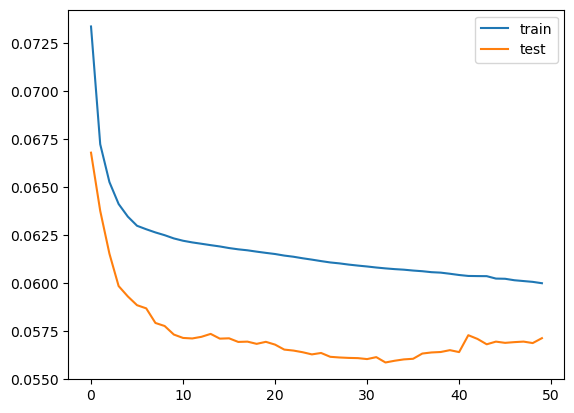

In [78]:
# plot loss curves
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel = "Number of Epochs"
pyplot.ylabel = "Loss"
pyplot.show()

The loss curve above informs us about whether we are underfitting or overfitting. Loss is calculated by the loss function, which calculates the difference between the model's predictions and the true values.

**Overfitting**: Characterized by a noticeable gap between training and validation loss values. This indicates the model is memorizing the training data instead of learning its patterns. So, are we overfitting? Although the graph makes it seem like there is a gap between the plots, the scale of the loss on the y-axis is tiny. The true gap is only about 0.01 to 0.005. So, we do not appear to be overfitting.

**Underfitting**: If both losses follow a similar trend, but at relatively high values, this indicates the model is unable to learn the data effectively. So, are we underfitting? We are also not underfitting. The loss never hits a high value.

##### **MAE vs. RMSE**
In his original tutorial, Jason used RMSE as his measurement of the performance of the dataset. MAE is, however, significantly easier to understand intuitively. So, we wanted to use MAE, but RMSE is better at finding significant errors, which is especially important since we are trying to predict human blood glucose levels. Luckily, we can use both to gain a better understanding of our dataset.

According to EUMeTrain.org, an international training project for the development of training material and training support in the field of satellite meteorology:

"The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude. Both the MAE and RMSE can range from 0 to ∞. They are negatively-oriented scores: Lower values are better."

So in the code cell below, we calculated MAE, RMSE, and the resulting Variance score.

In [79]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
import numpy as np

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_timesteps*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MAE
mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)
# calculate RMSE
rmse = np.sqrt(root_mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate Variance
variance = rmse - mae
print('Test Variance: %.3f' % variance)

2530/2530 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test MAE: 5.855
Test RMSE: 7.418
Test Variance: 1.563


Running the code cell above results in an MAE of 5.816, an RMSE of 7.404, and a variance of 1.587. Compared to our random selection baseline, MAE and RMSE were about half the size of random selection (MAE=8.742, RMSE=9.760, Variance=1.018). In other words, our model was about twice as accurate as random selection. However, our variance is actually higher than baseline by about 0.5. Compared to our mean selection baseline, MAE and RMSE were also about half the size of mean selection. In other words, our model was about twice as accurate as mean selection (MAE=8.778, RMSE=9.746, Variance=0.968). However, our variance is actually higher than baseline by about 1.1. It is somewhat unsurprising that selecting for the mean had the lowest variance, as it is the mean.

It is somewhat concerning that our variance is worse, but still, our variance is very low, and so it is unlikely that very large errors have occur. MAE tells us that the average difference between the forecasted BG level and the observed was 5.8 mg/dL. The monitor our data came from records BG level in a range from 0 to 400 mg/dL. Our MAE of 5.816 is only about 2.1% ((5.816 / 400) * 100 = 1.454). So, on average, our model's predicted BG level is only about 1.5% off of the actual level.

# Tuning

### Are we overfitting? Underfitting? How do we tell?

From our research of the LSTM model one of the best indications to **Overfitting** and **Underfitting** is the use of a Loss Curve. They provide a visual representation of how well the model learns from the training data and generalizes to unseen validation data. For sequential models like LSTMs, which are sensitive to patterns in time-series data, loss curves can reveal: If the model captures the underlying structure of the data; Whether the model is overfitting to the training set or underfitting, failing to learn effectively; How efficiently the model is converging during training.

#### Interpreting Overfitting and Underfitting for LSTM w/ Loss Curves
To determine if an LSTM model is overfitting or underfitting, specific patterns in the loss curves can be examined:

1. Overfitting:
   * Divergence Between Training and Validation (Test) Loss.
   * A noticeable gap between training and validation loss indicates the model is memorizing the training data instead of learning its patterns.
   * This would mean that the model is failing to generalize to unseen data, reducing its practicallity.

2. Underfitting:
   * Both training and validation losses stay high and dont significantly decrease over epochs.
   * If both losses follow a similar trend, but at relatively high values, showing the model is unable to learn the data effectively.
   * This means the model lacks the capacity to capture the complexity of the data.

3. Optimal Outcomes:
   * Both training and validation losses decrease together and eventually stabilize at low values.
   * The validation loss is slightly higher than the training loss but closely follows its trend, this indicates solid generalization.


#### Results for Our Model
In our case, the loss curves for both training and validation datasets show steady decreases over the epochs, for both losses stabilizing at low values.
Specifically: 
* Training Loss: Decreases steadily to approximately 0.0604
* Validation Loss: Closely follows the training loss, decreasing to approximately 0.0565 with no signs of divergence.

This Indicates that our model:
1. Is not overfitting: The validation loss does not increase or plateau while the training loss decreases.
2. Is not underfitting: Both losses decrease and stay at low values, suggesting that the model has effectively learned the patterns in our data.
3. Is well-trained and generalizes effectively to unseen data.
4. It captures the temporal dependencies in the time-series data without overfitting.
5. Has good training stability seen through the steadiness of curves between both losses.
6. The lower validation loss could be the result of differing noise levels in the training and testing sets.


### What is the optimal number of timesteps?
In this cell, we trained a version of the LSTM using different amounts of timesteps. In other words, we tested to see how many 5 minute intervals into the past we should use as input into the model.

In [80]:
import sys
def findNumTimestamps(num_timesteps=[10]):
    timesteps_best = None
    mae_best = sys.maxsize
    for i in num_timesteps:
        n_timesteps = i
        df_reframed = series_to_supervised(scaled, n_in=n_timesteps, n_out=7)
        # Split into train and test sets
        values = df_reframed.values[:len(df_reframed.values)//32]
        index_midpoint = len(values) // 2
        train = values[:index_midpoint,:]
        test = values[index_midpoint:,:]
        # Split into input and outputs
        n_features = len(df.columns)
        n_obs = n_timesteps * n_features
        train_X, train_y = train[:, 0:n_obs], train[:, -n_features]
        test_X, test_y = test[:, 0:n_obs], test[:, -n_features]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))
        # design LSTM
        model = Sequential()
        model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
        model.add(LSTM(100))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        # fit LSTM
        model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], n_timesteps*n_features))
        # invert scaling for forecast
        inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate MAE
        mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
        if mae < mae_best:
            timesteps_best = n_timesteps
            mae_best = mae
    return timesteps_best, mae_best

print(findNumTimestamps([5,10,15,24,48]))

Epoch 1/50
36/36 - 1s - 26ms/step - loss: 0.0991 - val_loss: 0.0600
Epoch 2/50
36/36 - 0s - 3ms/step - loss: 0.0597 - val_loss: 0.0578
Epoch 3/50
36/36 - 0s - 3ms/step - loss: 0.0568 - val_loss: 0.0574
Epoch 4/50
36/36 - 0s - 3ms/step - loss: 0.0565 - val_loss: 0.0572
Epoch 5/50
36/36 - 0s - 3ms/step - loss: 0.0563 - val_loss: 0.0571
Epoch 6/50
36/36 - 0s - 3ms/step - loss: 0.0562 - val_loss: 0.0569
Epoch 7/50
36/36 - 0s - 3ms/step - loss: 0.0559 - val_loss: 0.0567
Epoch 8/50
36/36 - 0s - 3ms/step - loss: 0.0557 - val_loss: 0.0565
Epoch 9/50
36/36 - 0s - 3ms/step - loss: 0.0555 - val_loss: 0.0564
Epoch 10/50
36/36 - 0s - 3ms/step - loss: 0.0553 - val_loss: 0.0562
Epoch 11/50
36/36 - 0s - 3ms/step - loss: 0.0550 - val_loss: 0.0560
Epoch 12/50
36/36 - 0s - 3ms/step - loss: 0.0550 - val_loss: 0.0558
Epoch 13/50
36/36 - 0s - 3ms/step - loss: 0.0549 - val_loss: 0.0556
Epoch 14/50
36/36 - 0s - 3ms/step - loss: 0.0545 - val_loss: 0.0555
Epoch 15/50
36/36 - 0s - 3ms/step - loss: 0.0542 - val_l

**Result**: MAE of about 5.527 using only 5 timesteps.

### What are the best LSTM hyperparameters?
We wanted to find what the optimal hyperparameters for the LSTM were. So, we've created a grid search to find the optimal hyperparameters. Batch size determines how many samples from our dataset the LSTM uses to compare itself to the prediction and calculate error. So we are going to test a batch size of varying intervals. Another hyperparameter is the number of epochs, which is the number of times the LSTM interates over the entire training dataset. Finally, we have the number of neurons in the LSTM. This effectively controls the number of hidden states the LSTM will use to "remember" previous states.

**APOLOGIES**: This code takes a very long time to run and we were not able to run it before having to turn in this assignment. Please refer to gridsearchresults.md to see the results of a previous run. It claimed that 5 neurons was the best, with 40 epochs, and a batch size of 10.

In [ ]:
# Split into train and test sets
values = df_reframed.values
index_midpoint = len(values) // 2
train = values[:index_midpoint,:]
test = values[index_midpoint:,:]
# Split into input and outputs
n_features = len(df.columns)
n_obs = n_timesteps * n_features
train_X, train_y = train[:, 0:n_obs], train[:, -n_features]
test_X, test_y = test[:, 0:n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))

# Gird Search implementation like the one explained in Lecture (takes 15 mins to run currently)
def GridSearchHyperparameters(num_neurons, num_epochs, batch_size, validation_data):
    neurons_best = None
    epochs_best = None
    batch_size_best = None
    mae_best = 1000000000000
    for neurons in num_neurons:
        for epochs in num_epochs:
            for batches in batch_size:
                print('------------------------------------')
                print("neurons: " + str(neurons), "epochs: " + str(epochs), "batches: " + str(batches))
                # reset data
                test_X = validation_data[0]
                test_y = validation_data[1]
                # design LSTM
                model = Sequential()
                model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
                model.add(LSTM(neurons))
                model.add(Dense(1))
                model.compile(loss='mae', optimizer='adam')
                # fit LSTM
                model.fit(train_X, train_y, epochs=epochs, batch_size=batches, validation_data=validation_data, verbose=0, shuffle=False)
                # make a prediction
                yhat = model.predict(test_X)
                test_X = test_X.reshape((test_X.shape[0], n_timesteps*n_features))
                # invert scaling for forecast
                inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:,0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:,0]
                # calculate MAE
                mae = np.sqrt(mean_absolute_error(inv_y, inv_yhat))
                # best MAE decision
                if mae < mae_best:
                    neurons_best = neurons
                    epochs_best = epochs
                    batch_size_best = batches
                    mae_best = mae
    return mae_best, neurons_best, epochs_best, batch_size_best


# Split into input and outputs
n_features = 4
n_obs = n_timesteps * n_features
train_X, train_y = train[:, 0:n_obs], train[:, -n_features]
test_X, test_y = test[:, 0:n_obs], test[:, -n_features]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps, n_features))
print(GridSearchHyperparameters(num_neurons=[5,10,25,50],
                                num_epochs=[10, 20, 40, 80],
                                batch_size=[10, 20, 40, 80],
                                validation_data=(test_X, test_y))
      )

------------------------------------
neurons: 5 epochs: 10 batches: 10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: operands could not be broadcast together with shapes (2530,4) (10,) (2530,4) 

# Results

We found that an LSTM would work best for our Time Series dataset problem. We used an LSTM and got an outcome twice as good as random and simple mean-prediction. We found that the best number of timesteps was 5. In other words, the model was best at predicting BG level when it was given data from the last 25 minutes (five 5 minute intervals.) With an MAE of 5.527, we somewhat improved upon our previous MAE of 5.816 using the timestep optimizer. Hyperparameter tests were inconclusive due to time limitations.

### Credits
* Jason Brownlee's tutorial on how to create a multivariate LSTM in Python @ https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* "The AI Hacker" on YouTube for his informative guide to RNNs @ https://youtu.be/LHXXI4-IEns?si=C4FoMP-Bv4xywsHZ
* EUMeTrain.org for their explanation of MAE, RMSE, and how to assess variance between them @ https://resources.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm


### Use of AI
Loading and Cleaning aspects of data. Help with understanding relevance of new topics and how they can specifically pertain to our project.